In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
import seaborn as sns


In [80]:
# Load the CSV file containing the labels
df = pd.read_csv('/content/drive/MyDrive/Fall_detectionp/labels.csv')

# Display the first few rows to check the data
print(df.head())

# Check label distribution
print(df['label'].value_counts())

# Map 'Fall' to 1 and 'Non-Fall' to 0
label_mapping = {'Non-Fall': 0, 'Fall': 1}
df['label'] = df['label'].map(label_mapping)

# Check the distribution again after mapping
print(df['label'].value_counts())


                                          image_path     label  x1  y1  x2  \
0  /content/drive/MyDrive/Fall_detectionp/Non_Fal...  Non-Fall  10  63  78   
1  /content/drive/MyDrive/Fall_detectionp/Non_Fal...  Non-Fall  11  63  80   
2  /content/drive/MyDrive/Fall_detectionp/Non_Fal...  Non-Fall  13  62  80   
3  /content/drive/MyDrive/Fall_detectionp/Non_Fal...  Non-Fall  14  62  79   
4  /content/drive/MyDrive/Fall_detectionp/Non_Fal...  Non-Fall  15  61  79   

    y2  
0  239  
1  239  
2  239  
3  239  
4  239  
label
Non-Fall    7748
Fall         573
Name: count, dtype: int64
label
0    7748
1     573
Name: count, dtype: int64


In [81]:
from PIL import Image
class FallDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.root_dir, row['image_path'])
        label = int(row['label'])
        x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])

        # Load and preprocess image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        image = image[y1:y2, x1:x2]  # Crop using bounding box
        image = cv2.resize(image, (32, 32))  #

        # Convert to PIL Image before applying transforms
        image = Image.fromarray(image)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [82]:
from torchvision import transforms

# Define transformations for data augmentation and preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 50%
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image within 15 degrees
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),  # Randomly crop and resize to 128x128
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean and std
])


In [83]:
from sklearn.model_selection import train_test_split

# Step 1: Split the dataset into 80% train and 20% (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 2: Further split the remaining 20% into 10% validation and 10% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Step 3: Verify the sizes of the splits
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Step 4: Create datasets for training, validation, and testing
train_dataset = FallDataset(train_df, root_dir='/content/drive/MyDrive/Fall_detectionp', transform=transform)
val_dataset = FallDataset(val_df, root_dir='/content/drive/MyDrive/Fall_detectionp', transform=transform)
test_dataset = FallDataset(test_df, root_dir='/content/drive/MyDrive/Fall_detectionp', transform=transform)

# Step 5: Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Training set size: 6656
Validation set size: 832
Test set size: 833


Batch size: 32


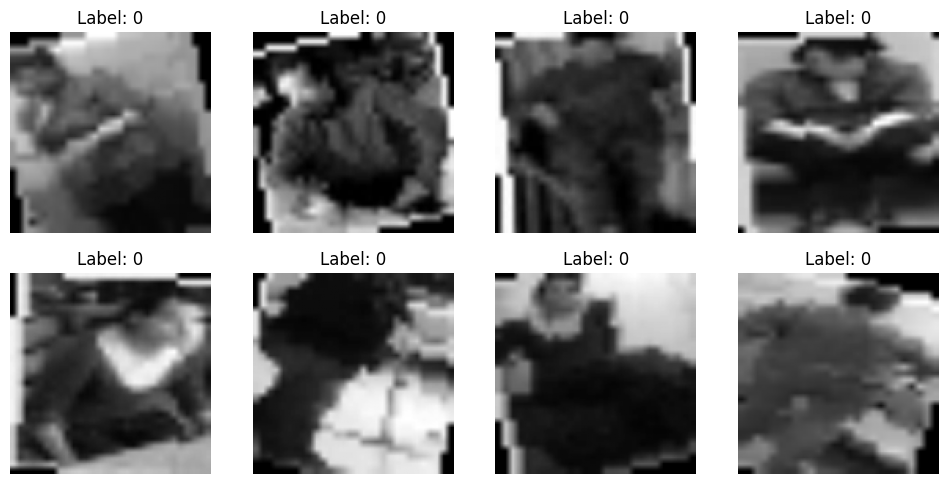

In [84]:
def plot_images(images, labels, n=8):
    """
    Plot the first `n` images from a batch, alongside their labels.
    """
    plt.figure(figsize=(12, 12))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        image = images[i].squeeze().numpy()  # Remove channel dimension
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Get a batch from the DataLoader and plot images
for images, labels in train_loader:
    print(f"Batch size: {images.shape[0]}")
    plot_images(images, labels)  # Plot the first 8 images in the batch
    break  # Only plot the first batch for illustration


##**Model: CNN_LSTM**

In [25]:
import torch
import torch.nn as nn

class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # LSTM layer
        # Calculate the correct input size based on the output of CNN layers
        # Assuming input image size is 128x128 after transformations:
        # After conv1 and pool: (128 / 2) = 64
        # After conv2 and pool: (64 / 2) = 32
        # So the output size is 64 channels x 32 x 32
        self.lstm = nn.LSTM(input_size=64 * 32 * 32, hidden_size=128, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 2)  # 2 classes: Fall and Non-Fall

    def forward(self, x):
        # CNN layers
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the image before LSTM
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, num_features)

        # LSTM layer
        x, (hn, cn) = self.lstm(x.unsqueeze(1))  # Add sequence dimension

        # Fully connected layers
        x = torch.relu(self.fc1(hn[-1]))  # Get the output from the last hidden state
        x = self.fc2(x)
        return x

Epoch [1/15], Train Loss: 0.2452, Train Accuracy: 92.56%, Val Loss: 0.1664, Val Accuracy: 92.91%
Epoch [2/15], Train Loss: 0.1018, Train Accuracy: 96.78%, Val Loss: 0.0626, Val Accuracy: 98.08%
Epoch [3/15], Train Loss: 0.0514, Train Accuracy: 98.45%, Val Loss: 0.0305, Val Accuracy: 99.28%
Epoch [4/15], Train Loss: 0.0348, Train Accuracy: 98.92%, Val Loss: 0.0262, Val Accuracy: 99.16%
Epoch [5/15], Train Loss: 0.0263, Train Accuracy: 99.17%, Val Loss: 0.0154, Val Accuracy: 99.40%
Epoch [6/15], Train Loss: 0.0199, Train Accuracy: 99.32%, Val Loss: 0.0174, Val Accuracy: 99.40%
Epoch [7/15], Train Loss: 0.0154, Train Accuracy: 99.52%, Val Loss: 0.0095, Val Accuracy: 99.76%
Epoch [8/15], Train Loss: 0.0147, Train Accuracy: 99.44%, Val Loss: 0.0249, Val Accuracy: 99.04%
Epoch [9/15], Train Loss: 0.0098, Train Accuracy: 99.77%, Val Loss: 0.0160, Val Accuracy: 99.28%
Epoch [10/15], Train Loss: 0.0101, Train Accuracy: 99.71%, Val Loss: 0.0213, Val Accuracy: 99.40%
Epoch [11/15], Train Loss: 0.

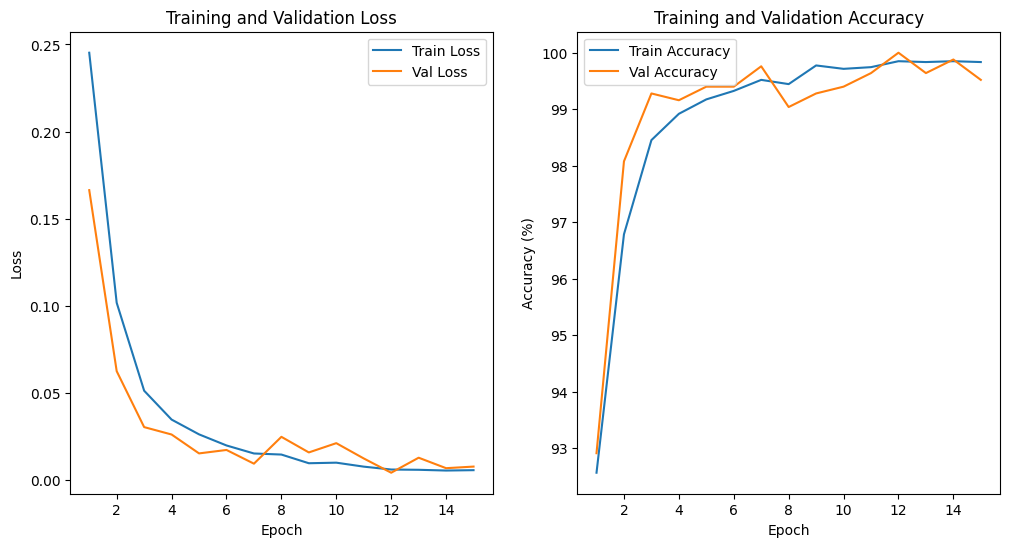

Test Accuracy: 99.52%


In [26]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {val_accuracies[-1]:.2f}%")

    scheduler.step()

# Plot training and validation performance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Test accuracy calculation
model.eval()
test_correct, test_total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

In [27]:
# Save the trained model
model_path = '/content/drive/MyDrive/CNN_LSTM.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/CNN_LSTM.pth


## **Model: CNN**

In [50]:
import torch
import torch.nn as nn

class SimpleCNNModel(nn.Module):
    def __init__(self):
        super(SimpleCNNModel, self).__init__()

        # Define the CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: 1 channel, Output: 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32 channels, Output: 64 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Input: 64 channels, Output: 128 channels
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with kernel size 2

        # Fully connected layers
        # Changed the input size to 128 * 4 * 4 to match the actual output size
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Flattened input size after 3 CNN layers and pooling
        self.fc2 = nn.Linear(512, 2)  # 2 classes: Fall and Non-Fall

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and pooling
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten (batch_size, 128 * 4 * 4)

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Epoch [1/15], Train Loss: 0.1381, Train Accuracy: 95.27%
Validation Loss: 0.0921, Validation Accuracy: 95.91%
Epoch [2/15], Train Loss: 0.0667, Train Accuracy: 97.72%
Validation Loss: 0.0487, Validation Accuracy: 98.08%
Epoch [3/15], Train Loss: 0.0462, Train Accuracy: 98.23%
Validation Loss: 0.0356, Validation Accuracy: 98.80%
Epoch [4/15], Train Loss: 0.0339, Train Accuracy: 98.59%
Validation Loss: 0.0243, Validation Accuracy: 99.04%
Epoch [5/15], Train Loss: 0.0305, Train Accuracy: 98.90%
Validation Loss: 0.0253, Validation Accuracy: 99.28%
Epoch [6/15], Train Loss: 0.0219, Train Accuracy: 99.19%
Validation Loss: 0.0136, Validation Accuracy: 99.52%
Epoch [7/15], Train Loss: 0.0194, Train Accuracy: 99.28%
Validation Loss: 0.0091, Validation Accuracy: 99.88%
Epoch [8/15], Train Loss: 0.0187, Train Accuracy: 99.22%
Validation Loss: 0.0286, Validation Accuracy: 98.92%
Epoch [9/15], Train Loss: 0.0139, Train Accuracy: 99.41%
Validation Loss: 0.0066, Validation Accuracy: 100.00%
Epoch [10

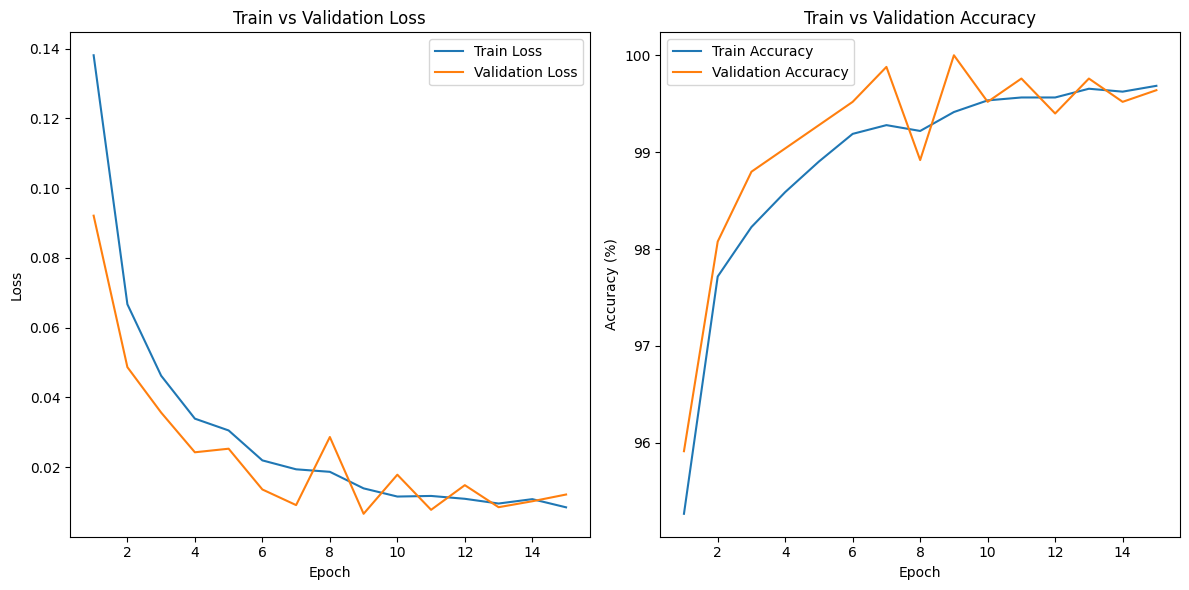

Model saved to /content/SimpleCNNModel.pth

Classification Report on Test Data:
              precision    recall  f1-score   support

    Non-Fall       1.00      1.00      1.00       787
        Fall       0.94      1.00      0.97        46

    accuracy                           1.00       833
   macro avg       0.97      1.00      0.98       833
weighted avg       1.00      1.00      1.00       833



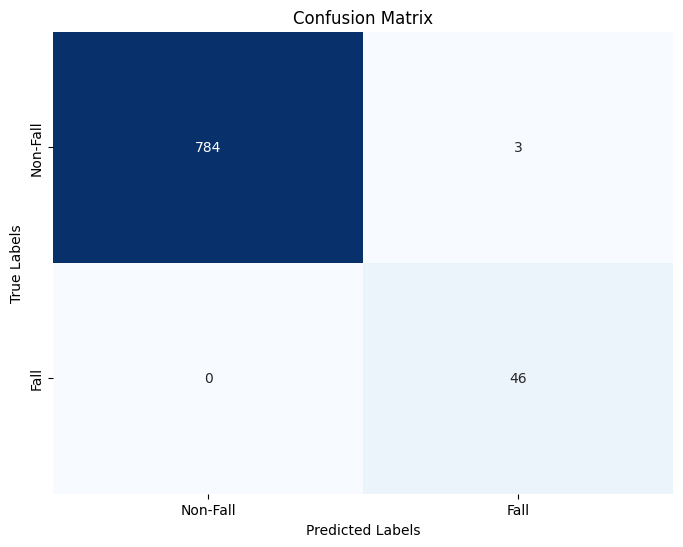

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Step 6: Model, criterion, and optimizer initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Step 7: Train the model
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Step 8: Test the model
model.eval()
test_correct, test_total = 0, 0
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Step 9: Plot train and validation metrics
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 10: Save the model
model_path = '/content/SimpleCNNModel.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Step 11: Print classification report on the test set
print("\nClassification Report on Test Data:")
print(classification_report(all_labels, all_preds, target_names=['Non-Fall', 'Fall']))

# Step 12: Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## **MobileNetV2-based**

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2Classifier, self).__init__()
        # Load the pre-trained MobileNetV2 model
        self.base_model = models.mobilenet_v2(pretrained=True)

        # Modify the first convolutional layer to accept 1 channel (grayscale)
        self.base_model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Modify the classifier layer for the correct number of output classes
        self.base_model.classifier[1] = nn.Linear(self.base_model.last_channel, num_classes)

    def forward(self, x):
        # No need to repeat channels if the input is already grayscale
        # return self.base_model(x)
        # The input is grayscale (1 channel), so no need to repeat it
        return self.base_model(x)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Train Loss: 0.2028, Train Accuracy: 92.70%
Validation Loss: 0.1244, Validation Accuracy: 93.51%
Epoch [2/15], Train Loss: 0.1013, Train Accuracy: 96.33%
Validation Loss: 0.0687, Validation Accuracy: 98.56%
Epoch [3/15], Train Loss: 0.0673, Train Accuracy: 98.14%
Validation Loss: 0.0623, Validation Accuracy: 97.36%
Epoch [4/15], Train Loss: 0.0469, Train Accuracy: 98.80%
Validation Loss: 0.0404, Validation Accuracy: 99.04%
Epoch [5/15], Train Loss: 0.0370, Train Accuracy: 99.05%
Validation Loss: 0.0308, Validation Accuracy: 98.80%
Epoch [6/15], Train Loss: 0.0329, Train Accuracy: 99.04%
Validation Loss: 0.0200, Validation Accuracy: 99.40%
Epoch [7/15], Train Loss: 0.0267, Train Accuracy: 99.29%
Validation Loss: 0.0240, Validation Accuracy: 99.16%
Epoch [8/15], Train Loss: 0.0236, Train Accuracy: 99.38%
Validation Loss: 0.0178, Validation Accuracy: 99.40%
Epoch [9/15], Train Loss: 0.0205, Train Accuracy: 99.49%
Validation Loss: 0.0226, Validation Accuracy: 99.40%
Epoch [10/

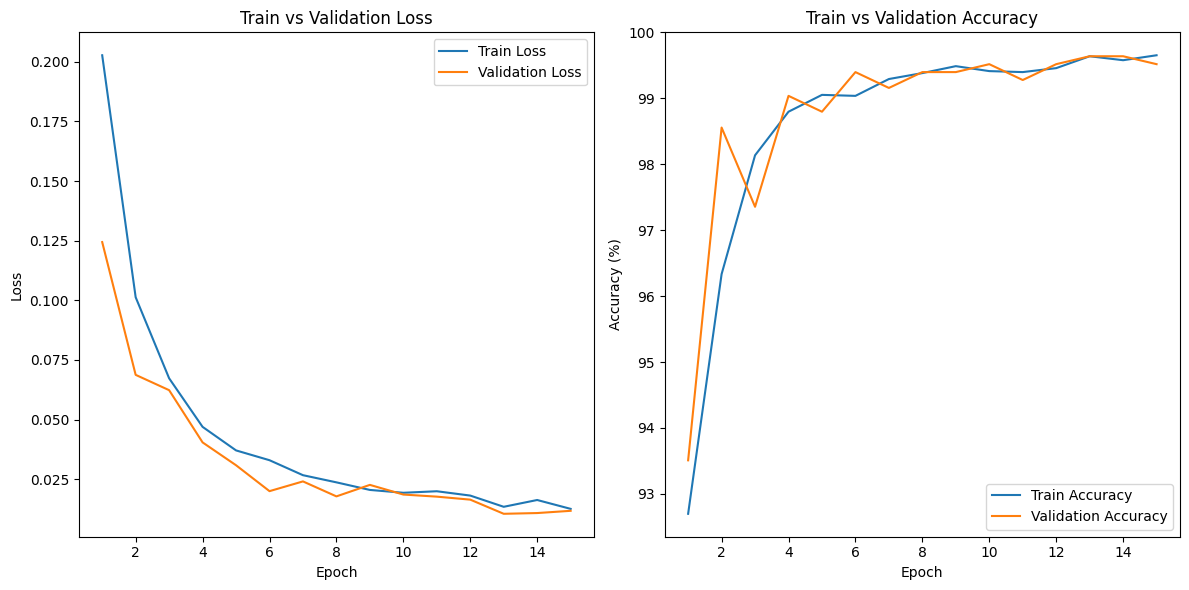

Model saved to /content/MobileNetV2Classifier.pth

Classification Report on Test Data:
              precision    recall  f1-score   support

    Non-Fall       1.00      1.00      1.00       787
        Fall       0.94      0.98      0.96        46

    accuracy                           1.00       833
   macro avg       0.97      0.99      0.98       833
weighted avg       1.00      1.00      1.00       833



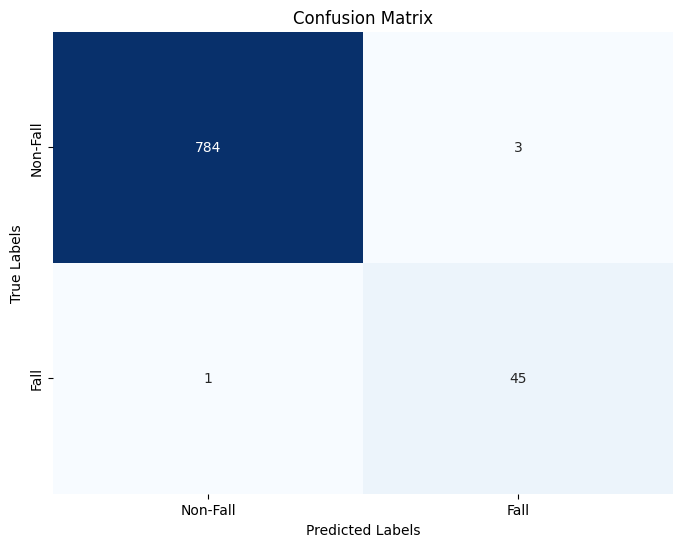

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



# Step 6: Model, criterion, and optimizer initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2Classifier(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Step 7: Train the model
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Step 8: Test the model
model.eval()
test_correct, test_total = 0, 0
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Step 9: Plot train and validation metrics
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 10: Save the model
model_path = '/content/MobileNetV2Classifier.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Step 11: Print classification report on the test set
print("\nClassification Report on Test Data:")
print(classification_report(all_labels, all_preds, target_names=['Non-Fall', 'Fall']))

# Step 12: Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## **ResNet-50 model**

In [85]:


# Define the ResNet-50 model class with fine-tuning
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.base_model = models.resnet50(pretrained=True)

        # Modify the first convolutional layer to accept 1 channel (grayscale)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Modify the classifier layer for the correct number of output classes
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


Epoch [1/15], Train Loss: 0.0721, Train Accuracy: 97.09%
Validation Loss: 0.0162, Validation Accuracy: 99.52%
Epoch [2/15], Train Loss: 0.0164, Train Accuracy: 99.50%
Validation Loss: 0.0097, Validation Accuracy: 99.76%
Epoch [3/15], Train Loss: 0.0151, Train Accuracy: 99.49%
Validation Loss: 0.0108, Validation Accuracy: 99.76%
Epoch [4/15], Train Loss: 0.0096, Train Accuracy: 99.74%
Validation Loss: 0.0236, Validation Accuracy: 99.16%
Epoch [5/15], Train Loss: 0.0123, Train Accuracy: 99.53%
Validation Loss: 0.0045, Validation Accuracy: 99.88%
Epoch [6/15], Train Loss: 0.0085, Train Accuracy: 99.79%
Validation Loss: 0.0443, Validation Accuracy: 98.56%
Epoch [7/15], Train Loss: 0.0098, Train Accuracy: 99.71%
Validation Loss: 0.0139, Validation Accuracy: 99.40%
Epoch [8/15], Train Loss: 0.0080, Train Accuracy: 99.76%
Validation Loss: 0.0131, Validation Accuracy: 99.52%
Epoch [9/15], Train Loss: 0.0048, Train Accuracy: 99.86%
Validation Loss: 0.0209, Validation Accuracy: 99.52%
Epoch [10/

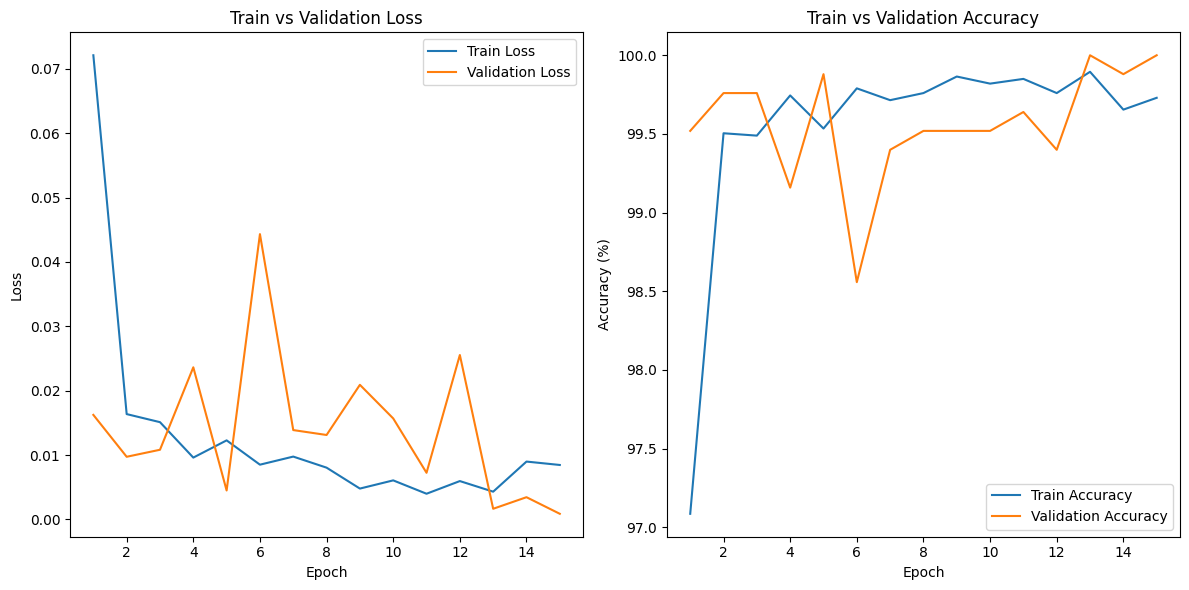

Model saved to /content/ResNet50Classifier.pth

Classification Report on Test Data:
              precision    recall  f1-score   support

    Non-Fall       1.00      1.00      1.00       787
        Fall       1.00      1.00      1.00        46

    accuracy                           1.00       833
   macro avg       1.00      1.00      1.00       833
weighted avg       1.00      1.00      1.00       833



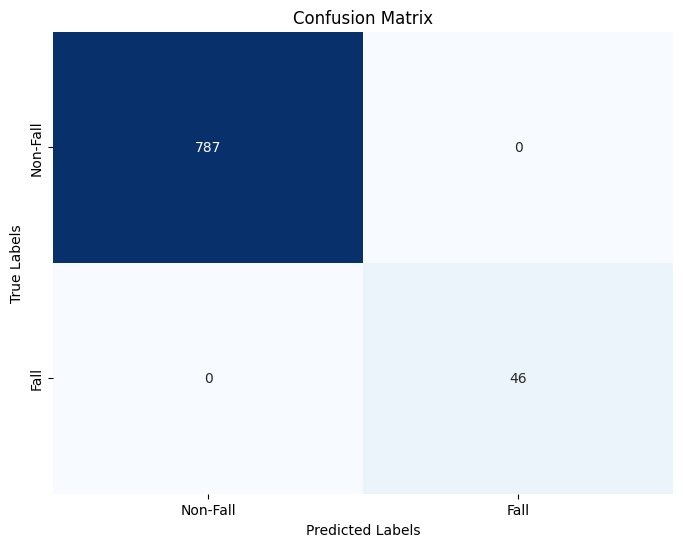

In [86]:


# Step 6: Model, criterion, and optimizer initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Classifier(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Step 7: Train the model
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Step 8: Test the model
model.eval()
test_correct, test_total = 0, 0
all_labels, all_preds = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Step 9: Plot train and validation metrics
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Step 10: Save the model
model_path = '/content/ResNet50Classifier.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Step 11: Print classification report on the test set
print("\nClassification Report on Test Data:")
print(classification_report(all_labels, all_preds, target_names=['Non-Fall', 'Fall']))

# Step 12: Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [87]:
from google.colab import files
!jupyter nbconvert --to html /content/Fall_detection.ipynb
files.download('/content/Fall_detection.html')


[NbConvertApp] Converting notebook /content/Fall_detection.ipynb to html
[NbConvertApp] Writing 407739 bytes to /content/Fall_detection.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>